In [1]:
import tensorflow as tf
print("TF Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TF Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

In [3]:
df = pd.read_csv("/content/train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
X = df["comment_text"]
y = df[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]]

In [5]:
MAX_FEATURES = 50000
SEQ_LEN = 300

vectorizer = TextVectorization(
    max_tokens=MAX_FEATURES,
    output_mode="int",
    output_sequence_length=SEQ_LEN
)

vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)


In [6]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(100000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(8)

train = dataset.take(int(len(dataset)*0.7))
val   = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test  = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [7]:
model = Sequential()

model.add(Embedding(MAX_FEATURES + 1, 32, input_length=SEQ_LEN))

model.add(Bidirectional(
    LSTM(32, activation='tanh', dropout=0.3)
))

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(256, activation="relu"))
model.add(Dropout(0.4))

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(6, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [8]:
history = model.fit(train, epochs=5, validation_data=val)
model.summary()

Epoch 1/5
3490/3490 ━━━━━━━━━━━━━━━━━━━━ 109s 28ms/step - accuracy: 0.8459 - loss: 0.0987 - val_accuracy: 0.9936 - val_loss: 0.0509
Epoch 2/5
3490/3490 ━━━━━━━━━━━━━━━━━━━━ 99s 28ms/step - accuracy: 0.9893 - loss: 0.0509 - val_accuracy: 0.9935 - val_loss: 0.0472
Epoch 3/5
3490/3490 ━━━━━━━━━━━━━━━━━━━━ 98s 28ms/step - accuracy: 0.9819 - loss: 0.0470 - val_accuracy: 0.9942 - val_loss: 0.0425
Epoch 4/5
3490/3490 ━━━━━━━━━━━━━━━━━━━━ 98s 28ms/step - accuracy: 0.9917 - loss: 0.0444 - val_accuracy: 0.9947 - val_loss: 0.0397
Epoch 5/5
3490/3490 ━━━━━━━━━━━━━━━━━━━━ 97s 28ms/step - accuracy: 0.9915 - loss: 0.0425 - val_accuracy: 0.9941 - val_loss: 0.0393


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 32)        │     1,600,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,075,060 (19.36 MB)

 Trainable params: 1,691,686 (6.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,383,374 (12.91 MB)

<Figure size 800x500 with 0 Axes>

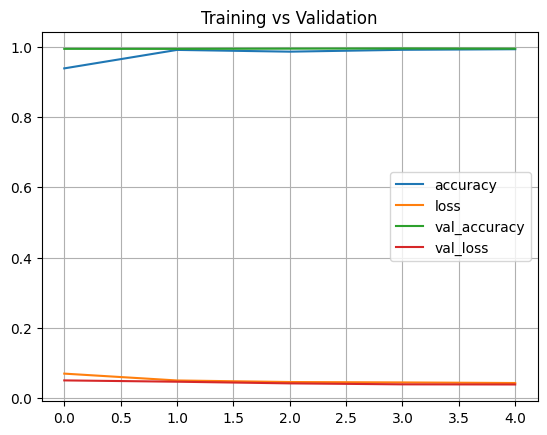

In [9]:
import pandas as pd
from matplotlib import pyplot as plt

plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.title("Training vs Validation")
plt.grid()
plt.show()


In [10]:
def classify(text):
    encoded = vectorizer([text])  # Convert to batch input
    pred = model.predict(encoded)[0]
    return pred, (pred > 0.5).astype(int)

text = "You freaking suck! I am going to hit you."
probabilities, label = classify(text)

print("Raw probabilities:", probabilities)
print("Binary prediction:", label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
Raw probabilities: [0.99579406 0.10745274 0.90828305 0.03586697 0.77582186 0.09002969]
Binary prediction: [1 0 1 0 1 0]


In [11]:
batch_X, batch_y = test.as_numpy_iterator().next()

preds = model.predict(batch_X)

binary_preds = (preds > 0.5).astype(int)

print("Batch shape:", batch_X.shape)
print("Pred shape:", binary_preds.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
Batch shape: (32, 300)
Pred shape: (32, 6)


In [12]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [13]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [14]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

In [15]:
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall:    {re.result().numpy():.4f}")
print(f"Accuracy:  {acc.result().numpy():.4f}")

Precision: 0.8773
Recall:    0.6613
Accuracy:  0.3193


In [16]:
!pip install gradio jinja2

In [17]:
import tensorflow as tf
import gradio as gr
import numpy as np

In [18]:
model.save('toxicity.h5')

In [19]:
model = tf.keras.models.load_model("toxicity.h5")

In [20]:
input_str = vectorizer(['You are a disgrace and a waste of space.'])
res = model.predict(input_str)
print(res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
[[0.6624532  0.00385076 0.16190068 0.01842834 0.23397201 0.03602004]]


In [21]:
# Scoring function
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ""
    for idx, col in enumerate(df.columns[2:]):
        text += "{}: {}\n".format(col, results[0][idx] > 0.5)

    return text

# UI
interface = gr.Interface(
    fn=score_comment,
    inputs=gr.Textbox(lines=2, placeholder="Comment to score"),
    outputs="text"
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://01e082c273bf469002.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
